<a href="https://colab.research.google.com/github/malikinza/Eigenfaces-for-Face-Recognition/blob/main/Eigenfaces_for_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Images are downloaded from [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/).

In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=e2971979c4b64cdfdf78942411337df33e100f85bb3d9f6c335180aa5a60e5f7
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import wget
import math

In [4]:
# Download and unzip dataset.
filename = wget.download('https://github.com/aps1070-2019/datasets/raw/master/lfw-a.tgz', 'lfw-a.tgz')
!tar -xvzf "{filename}"

lfw/Aaron_Eckhart/
lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw/Aaron_Guiel/
lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw/Aaron_Patterson/
lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw/Aaron_Peirsol/
lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw/Aaron_Pena/
lfw/Aaron_Pena/Aaron_Pena_0001.jpg
lfw/Aaron_Sorkin/
lfw/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw/Aaron_Tippin/
lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw/Abba_Eban/
lfw/Abba_Eban/Abba_Eban_0001.jpg
lfw/Abbas_Kiarostami/
lfw/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw/Abdel_Aziz_Al-Hakim/
lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw/Abdel_Madi_Shabneh/
lfw/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw/Abdel_Nasser_Assidi/
lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0002.jpg
lfw/Abdoulaye_Wade/
lfw/Abdoulay

In [5]:
# constants
IMAGE_DIR = 'lfw'
DEFAULT_SIZE = [250, 250] 

In [6]:
# Reads images from filesystem and returns Array of images and imageNames.
def readImages(imagePath = IMAGE_DIR, defaultSize = DEFAULT_SIZE):
    images = []
    imageNames = []
    imageDirs = [image for image in os.listdir(imagePath) if not image.startswith('.')]

    for imageDir in imageDirs:
        dirPath = os.path.join(imagePath, imageDir)
        dirImageNames = [image for image in os.listdir(dirPath) if not image.startswith('.')]
        
        for imageName in dirImageNames:
            image = Image.open(os.path.join(dirPath, imageName))
            image = image.convert ("L") # L stands for Luminance: converts image to grayscale
            
            if (defaultSize is not None):
                image = image.resize(defaultSize, Image.ANTIALIAS) # resize image
                
            images.append(np.asarray(image, dtype = np.uint8))
            imageNames.append(imageDir)
    return [images, imageNames]

In [7]:
[X, y] = readImages()

In [8]:
type(X), len(X)

(list, 1054)

In [9]:
type(X[0]), X[0].shape

(numpy.ndarray, (250, 250))

In [10]:
type(y), len(y)

(list, 1054)

Image name is:  Abdel_Madi_Shabneh


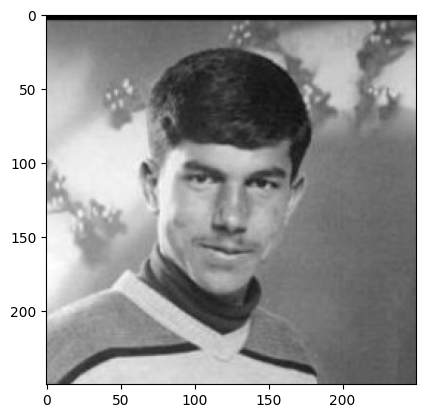

In [13]:
print('Image name is: ', y[2])
plt.imshow(X[2], cmap=plt.cm.gray)
plt.show()

In [14]:
#creating a mean face from all dataset faces
def asRowMatrix(X):
    if len(X) == 0: return np.array([])
    rowMatrix = np.empty((0, X[0].size), dtype = X[0].dtype)
    for img in X:
        rowMatrix = np.vstack((rowMatrix, np.asarray(img).reshape(1, -1)))
    return rowMatrix

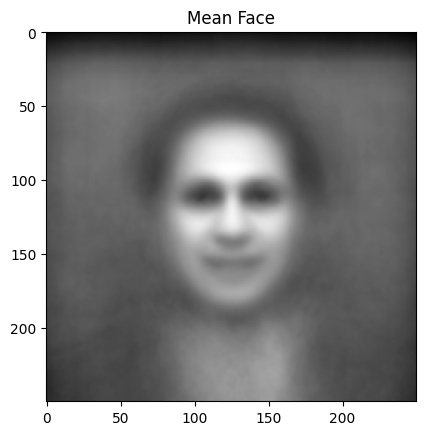

In [15]:
XMat = asRowMatrix(X);
meanImage = np.reshape(XMat.mean(axis=0), X[0].shape)
plt.imshow(meanImage, cmap=plt.cm.gray)
plt.title('Mean Face')
plt.show()

In [16]:
#computing eigenvectors and eigenvalues using covariance matrix

def getBasisCountThatPreservesVariance(eigenValues, variance=.95):
    for idx, cumulativeSum in enumerate(np.cumsum(eigenValues) / np.sum(eigenValues)):
        if cumulativeSum > variance:
            return idx
        
def pca(X, y):
    n, d = X.shape
    mu = X.mean(axis=0)
    X = X - mu # standardising data
    
    if n > d:
        C = np.dot(X.T, X) # covariance matrix
        eigenValues, eigenVectors = np.linalg.eigh(C)
    else:
        C = np.dot(X, X.T) # covariance matrix
        eigenValues, eigenVectors = np.linalg.eigh(C)
        eigenVectors = np.dot(X.T, eigenVectors)
        for i in range(n):
            eigenVectors[:,i] = eigenVectors[:, i] / np.linalg.norm(eigenVectors[:, i])
            
    # sort eigenVectors in descending order by their eigenValue
    idx = np.argsort(-eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    
    # select based on numOfBasis
    numOfBasis = getBasisCountThatPreservesVariance(eigenValues)
    print('Number of useful eigenBasis are: ', numOfBasis)
    eigenValues = eigenValues[0:numOfBasis].copy()
    eigenVectors = eigenVectors[:, 0:numOfBasis].copy()
    return eigenValues, eigenVectors, mu

In [17]:
eigenValues, eigenVectors, mean = pca(XMat, y)

Number of useful eigenBasis are:  298


In [ ]:
# Above code in pca method is written because below code is computationally time taking.
# C = np.dot(XMat.T, XMat) # covariance matrix
# eigenValues, eigenVectors = np.linalg.eigh(C)

In [19]:
eigenVectors.shape

(62500, 298)

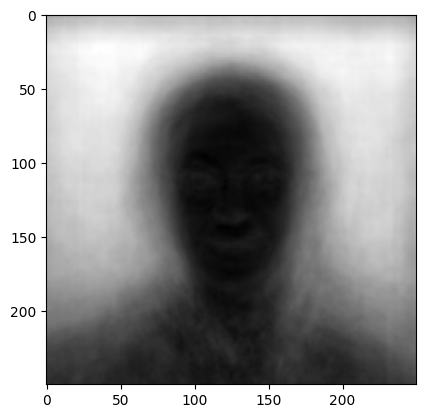

In [20]:
# show the first eigenFace
plt.imshow(eigenVectors[:, 0].reshape(-1, 250), cmap = plt.cm.gray)

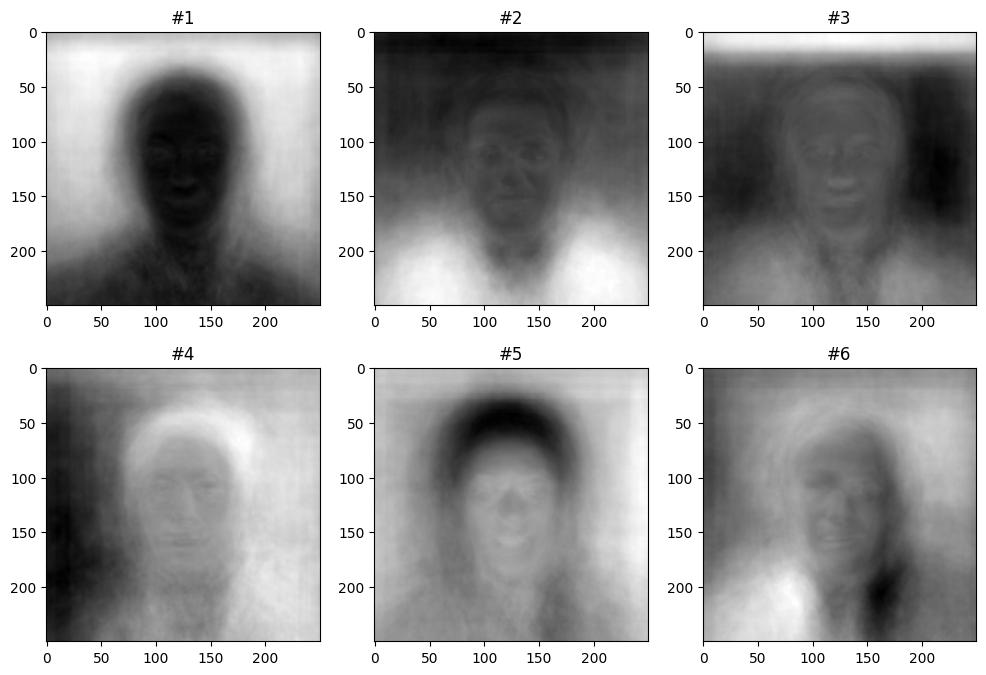

In [21]:
# print first 6 eigen faces
COUNT = 6
ROWS = math.ceil(COUNT/3)
fig = plt.figure(figsize=(12, ROWS * 4))
for i in range(0, COUNT):
    plt.subplot(ROWS, 3, i+1)
    plt.imshow(eigenVectors[:, i].reshape(-1, 250), cmap = plt.cm.gray)
    plt.title('#{}'.format(i+1))

In [22]:
IMAGE_IDX = 10 # image idx in dataset

In [23]:
def project (W , X , mu):
    return np.dot (X - mu , W)
def reconstruct (W , Y , mu) :
    return np.dot (Y , W.T) + mu

In [24]:
# create reconstructed images from eigenfaces (eigenvectors)
COUNT = 6 # count of first eigenVectors used to reconstruct the image
reconImages = []
for numEvs in range (1, COUNT+1):
    P = project(eigenVectors[:, 0:numEvs], X[IMAGE_IDX].reshape(1, -1), mean)
    R = reconstruct(eigenVectors[:, 0:numEvs], P, mean)
    reconImages.append(R.reshape(X[0].shape))

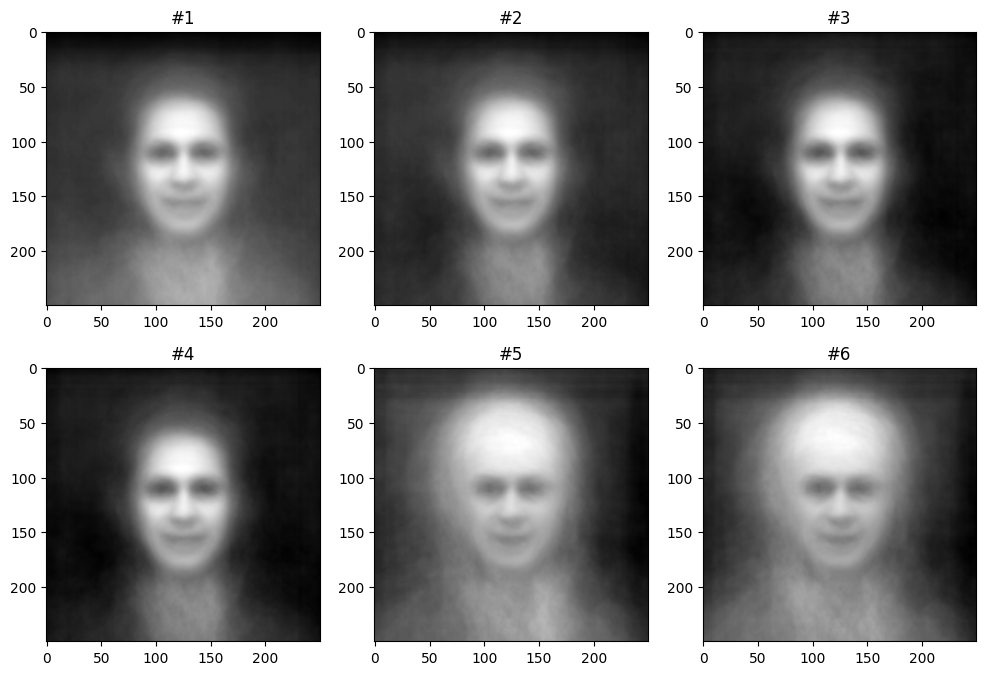

In [25]:
# plot reconstructed images
ROWS = math.ceil(COUNT/3)
fig = plt.figure(figsize=(12, ROWS * 4))
for i in range(0, COUNT):
    plt.subplot(ROWS, 3, i+1)
    plt.imshow(reconImages[i], cmap = plt.cm.gray)
    plt.title('#{}'.format(i+1))

In [26]:
# create reconstructed images
numEvsSet = [100, 200, 298] # these no. of eigenVectors will be used to reconstruct the image.
COUNT = len(numEvsSet)
reconImages = []
for numEvs in numEvsSet:
    P = project(eigenVectors[:, 0:numEvs], X[IMAGE_IDX].reshape(1, -1), mean)
    R = reconstruct(eigenVectors[:, 0:numEvs], P, mean)
    reconImages.append(R.reshape(X[0].shape))

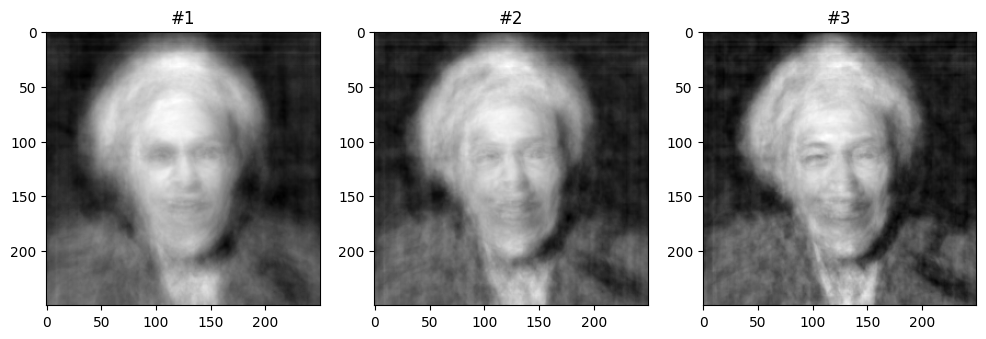

In [27]:
# plot reconstructed images
ROWS = math.ceil(COUNT/3)
fig = plt.figure(figsize=(12, ROWS * 4))
for i in range(0, COUNT):
    plt.subplot(ROWS, 3, i+1)
    plt.imshow(reconImages[i], cmap = plt.cm.gray)
    plt.title('#{}'.format(i+1))

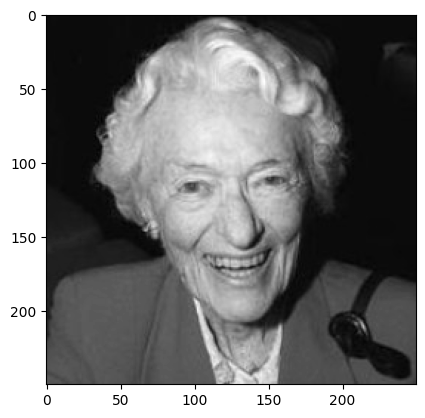

In [28]:
# actual image
plt.imshow(X[IMAGE_IDX], cmap=plt.cm.gray)
plt.show()